# Imports

## Libraries

In [71]:
import random
import warnings
warnings.filterwarnings('ignore')
import shapely
import geopandas as gpd
from shapely.ops import unary_union
# from pysal.esda.mapclassify import User_Defined
import mapclassify as mc
# mc.UserDefined works https://pysal.org/mapclassify/generated/mapclassify.UserDefined.html
from functions import *

## Data

In [2]:
# how much smaller are these notebooks than the last ones?

charts to make:
- region popularity for each city 
- culinary regions overall
- culinary region for each city
- total region popularity coupled with remittance data 

In [3]:
rest_df = pd.read_csv("../my_saved_data/final_correct_restaurants_and_regions.csv", index_col=0)

In [4]:
with open("../my_saved_data/demonym_dictionary.pickle", "rb+") as f:
    demonym_dict = pickle.load(f)

In [60]:
cul_reg_for_all = pd.read_csv("../my_saved_data/culinary_region_pct_overal.csv", index_col=0)
pct_df = pd.read_csv("../my_saved_data/city_region_pct_df.csv", index_col=0)
city_w_cul_reg_pct = pd.read_csv("../my_saved_data/city_w_culinary_region_pct.csv", index_col=0)

In [6]:
mex_gdf = gpd.read_file("../data/MEX_adm1.shp")

In [7]:
remit_df = pd.read_excel("../data/remittances_2020.xlsx", header=7)
remit_df.columns = ['X', "State", "Oct-Dec 2019", "Jan-Mar 2020", "Y"]

In [8]:
mex_pop = pd.read_csv("../data/mex_population_by_state.csv")

# Engineering Geodataframe

In [9]:
mex_gdf.drop(columns = ['ID_0', 'ID_1', 'ISO', 'NAME_0', 'HASC_1', 'CC_1', 'VALIDFR_1', 'VALIDTO_1', 'REMARKS_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1'], inplace=True)

regions_for_gdf = [unidecode.unidecode(x) for x in mex_gdf['NAME_1']]
mex_gdf['Region'] = [x.title() for x in regions_for_gdf]
mex_gdf['Region'].replace(region_replacement_dictionary, inplace=True)

# Region Popularity for Each City 

In [10]:
mex_gdf_w_reg_pct = mex_gdf.merge(pct_df, left_on = 'Region', right_on = 'Region', how='outer')

In [11]:
# making sure that it has 32 columns
assert mex_gdf_w_reg_pct.shape[0] == 32

# Culinary Region Popularity for Each City

In [14]:
region_to_cul_reg_dict = turn_regions_to_cul_regions()

## Combine geometries in gdf

In [17]:
mex_gdf['Culinary_region'] = mex_gdf['Region'].replace(region_to_cul_reg_dict)

In [19]:
# combine all of the culinary regions with the geometries
cul_reg_geometry_dict = {key: [] for key in cul_reg_dict.keys()}

for idx, item in enumerate(mex_gdf['Culinary_region']):
    cul_reg_geometry_dict[item].append(mex_gdf['geometry'][idx])

In [22]:
# combining the polygons into one unit 
polygon_list = []
for key in cul_reg_geometry_dict.keys():
    polygon = []
    for idx, cul_region in enumerate(mex_gdf.Culinary_region):
        if key == cul_region:
            polygon.append(mex_gdf.geometry[idx])
    polygon_list.append(polygon)
combined_polygon_list = []
for x in polygon_list:
    boundary = gpd.GeoSeries(unary_union(x)) 
    combined_polygon_list.append(boundary)

In [29]:
# adding all of the data to a new (g)df
cul_regions = list(key for key in cul_reg_dict.keys())
cul_reg_df = pd.DataFrame(data = cul_regions,
                         columns = ['Culinary_region'])
cul_reg_df['geometry'] = [x.values[0] for x in combined_polygon_list]
cul_reg_gdf = gpd.GeoDataFrame(cul_reg_df, geometry = cul_reg_df.geometry)

In [62]:
cul_reg_gdf_w_pct1 = cul_reg_gdf.merge(city_w_cul_reg_pct, left_on = 'Culinary_region', right_on = 'Cul_reg',
                  how='outer')
cul_reg_gdf_w_pct = cul_reg_gdf_w_pct1.merge(cul_reg_for_all, left_on = 'Culinary_region', 
                                             right_on = 'Culinary_region', how='outer')

In [65]:
cul_reg_gdf_w_pct.head(1)

,Culinary_region,geometry,NYC_pct,Chi_pct,Dal_pct,SF_pct,Restaurant,Percentage
0,North,"MULTIPOLYGON (((-114.73930 18.37431, -114.7393...",0.13,0.13,0.25,0.4,81,0.17


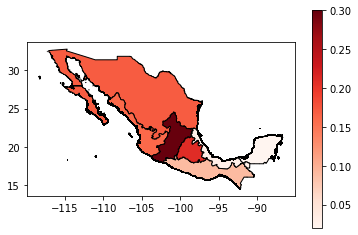

In [66]:
cul_reg_gdf_w_pct.plot(column='Percentage', legend=True, cmap='Reds', edgecolor='black')